In [1]:

import numpy as np 
import pandas as pd 
import ast
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps


# step 1

In [2]:
categories = ['apple','banana']
label_dict = {0:'apple',1:'banana'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv(category + ".csv")
    classes[category] = data

In [3]:
# Image manipulation utilities: 

def convert_to_PIL(drawing, width = 256, height = 256):

    
    # init
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()
            
    draw = ImageDraw.Draw(pil_img)
    
    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)
        
    return pil_img

def convert_to_np_raw(drawing, width = 256, height = 256):

    # init array
    img = np.zeros((28, 28))
    
    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)
    
    #resize to 28,28
    pil_img.thumbnail((28,28), Image.ANTIALIAS)
    
    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()
    
    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255
    
    return img



def view_image(img, width = 256, height = 256):
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()
    






In [4]:
values_dict = {}
for category in categories:
    data = classes[category][:300]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    

X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
    
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

In [5]:
def view_images_grid(X, y):

    fig, axs = plt.subplots(5, 5, figsize=(50,50))
    
    for label_num in range(0,25):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 5
        j = label_num % 5
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        
        axs[i,j].set_title( label_dict[y[r_label]] ,fontsize=50)

    plt.show()

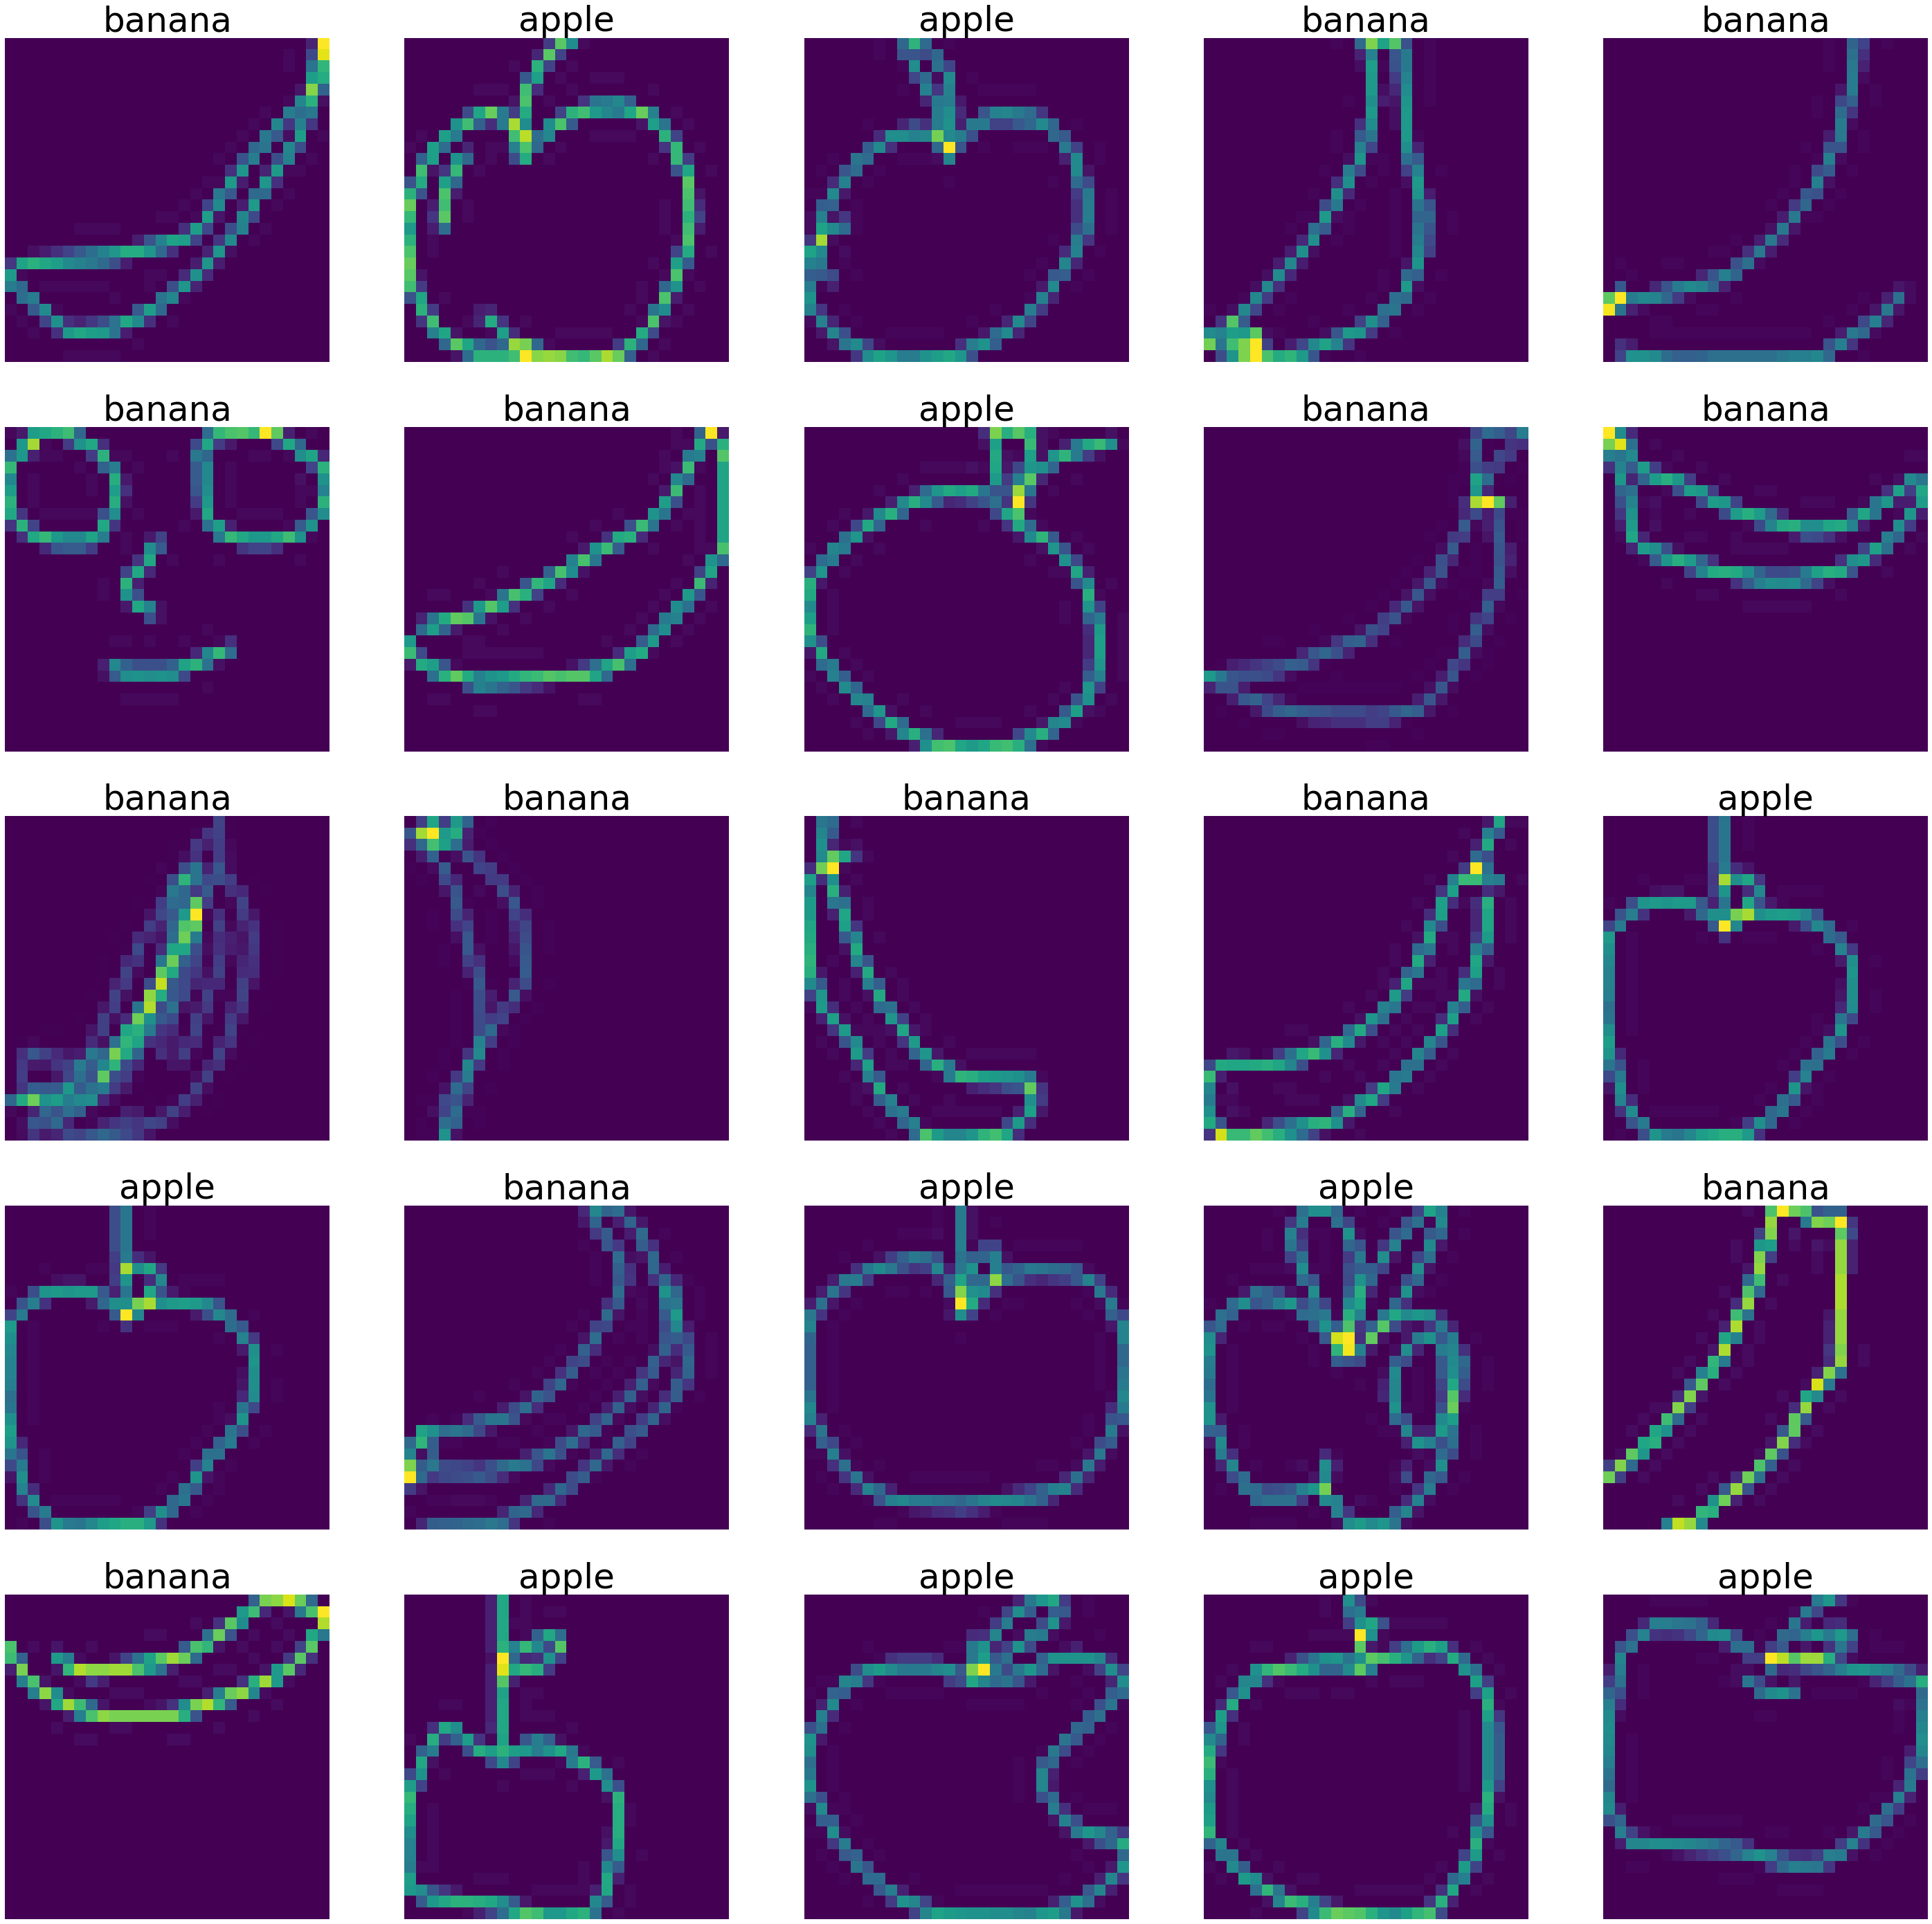

In [6]:
view_images_grid(X, y)

In [16]:
def npToImage(img):
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img


def toNp(pil_img, width = 256, height = 256):
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def flip(src_im):
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im


def rotate(src_im, angle = 45, size = (28,28)):
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im


(-0.5, 27.5, 27.5, -0.5)

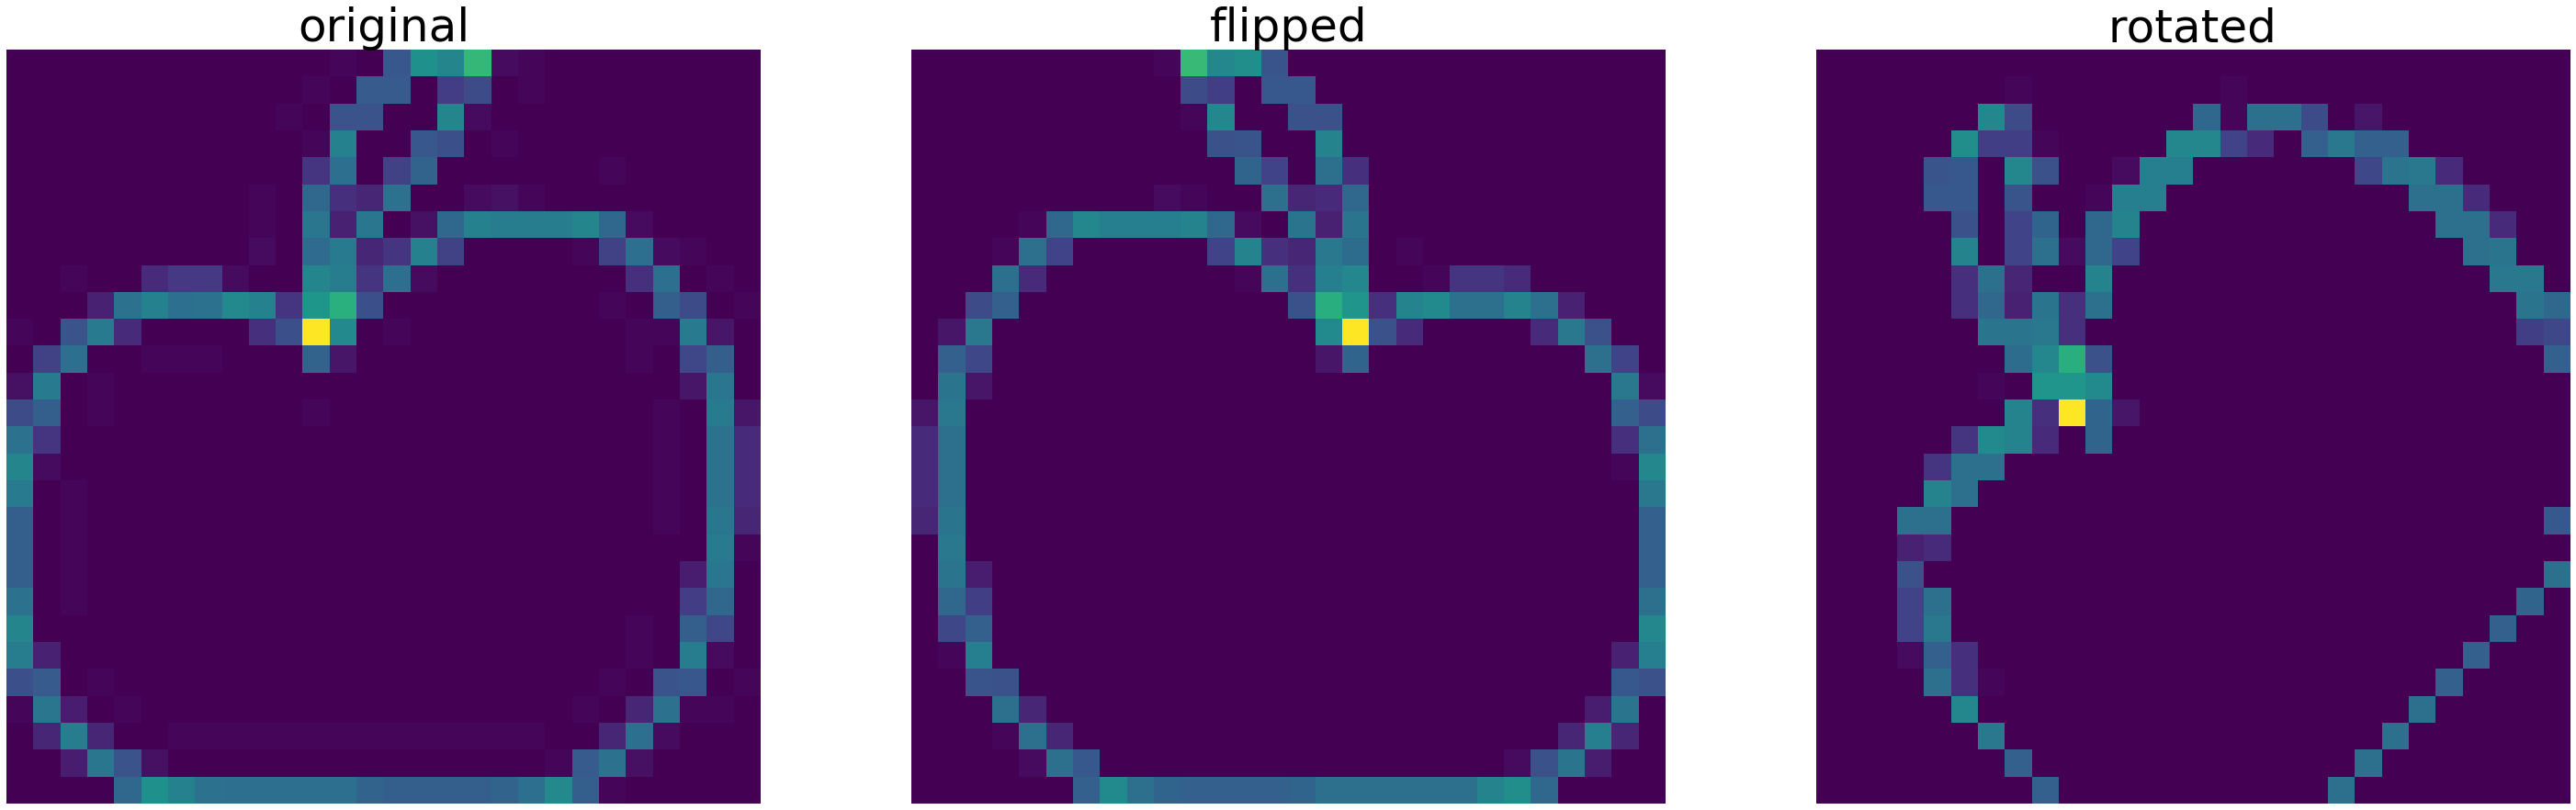

In [25]:
fig, axs = plt.subplots(1,3, figsize=(50,50))

np_img = X[100]
np_img_flipped = toNp(flip(npToImage(np_img)), 28, 28)
np_img_rotated = toNp(rotate(npToImage(np_img)), 28, 28)

axs[0].set_title('original', fontsize = 50)
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

axs[1].set_title('flipped', fontsize = 50)
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

axs[2].set_title('rotated', fontsize = 50)
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')